# Machine Learning in High-Energy Physics: Anomaly Detection as an Illustrative Example

## Jupyter notebook example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from __future__ import print_function
from glob import glob
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

## Section 1: Generating Events

#### Fig J1
Dijet event rate

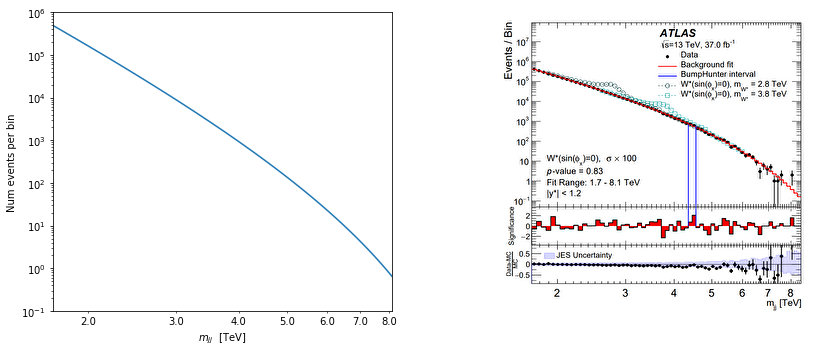

In [4]:
def dNbydM(m,p0,p1,p2):
    return p0*(1-(m/13))**p1/(m/13)**p2

p0 = 0.5*10**1
p1 = 5.
p2 = 6.
x = np.arange(1.7,8.11,0.1)
y = [dNbydM(m,p0,p1,p2) for m in x]

atlas_image = mpimg.imread("Capture.PNG")

fig, ax = plt.subplots(1,2,figsize=(14,5), gridspec_kw={'width_ratios':[1,2]})
ax1, ax2 = ax
ax1.plot(x,y)
ax1.semilogy()
ax1.semilogx()
ax1.set_xlabel(r"$m_{jj}$  [TeV]")
ax1.set_ylabel("Num events per bin")
ax1.set_xlim([1.7,8.1])
ax1.set_ylim([10**-1,10**6])
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter())
ax1.set_yticks(np.logspace(-1,6,8))
ax1.margins(1000,0)

ax2.imshow(atlas_image[:1000,:,:],interpolation='sinc')
ax2.set_axis_off()
ax2.margins(x=0.4,y=0.4)
# ax2.axis('off')
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Define bins to be the same (at least roughly) as ATLAS dijets, then restrict to narrower mass range.

In [5]:
bin_boundaries = np.logspace(np.log10(1.7),np.log10(8.1),67)
bin_boundaries = bin_boundaries[7:-20]
bin_midpoints = np.array([(bin_boundaries[i+1] + bin_boundaries[i])/2 for i in range(len(bin_boundaries)-1)])
bin_widths = np.array([bin_boundaries[i+1] - bin_boundaries[i] for i in range(len(bin_boundaries)-1)])

# Generate bg events
bg_bincounts = [np.random.poisson(dNbydM(m,p0,p1,p2)) for m in bin_midpoints]
ndim=2
bgevents = [np.clip(np.random.normal(0,1,(bincount,ndim)),-4,4) for bincount in bg_bincounts]

# Generate signal events as a Gaussian in mJJ
signal_distribution = np.random.normal(2.97,0.06,150)
signal_bincounts = np.histogram(signal_distribution,bins=bin_boundaries)[0]

#### Fig J2
Simulated dijet background and signal rates

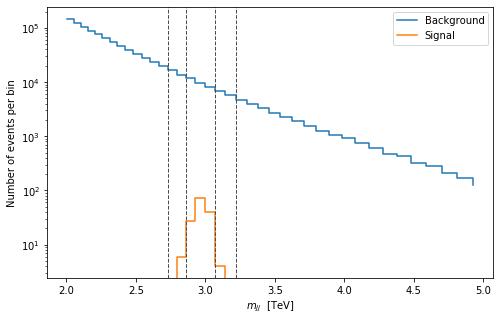

In [6]:
plt.figure(figsize=(8,5))
plt.step(bin_boundaries[:-1],bg_bincounts,where='post',label="Background")
plt.step(bin_boundaries[:-1],signal_bincounts,where='post',label="Signal")
plt.semilogy()
#plt.semilogx()
plt.ylabel("Number of events per bin")
plt.xlabel(r"$m_{jj}$  [TeV]")
plt.axvline(bin_boundaries[18],color='0.3',linestyle='--',linewidth=1.)
plt.axvline(bin_boundaries[15],color='0.3',linestyle='--',linewidth=1.)
plt.axvline(bin_boundaries[20],color='0.3',linestyle='--',linewidth=1.)
plt.axvline(bin_boundaries[13],color='0.3',linestyle='--',linewidth=1.)
plt.legend()
plt.show()

Check S/B and S/sqrt(B) around signal peak

In [7]:
print("Signal events =",signal_bincounts[14:19])
print("BG events =",bg_bincounts[14:19])
print("S/sqrt(B) =",signal_bincounts[14:19]/np.sqrt(bg_bincounts[14:19]))
print("S/B =",1.*signal_bincounts[14:19]/bg_bincounts[14:19])
print("S/B in central three bins =",np.sum(signal_bincounts[15:18])/np.sum(bg_bincounts[15:18]))
print("S/sqrt(B) in central three bins =",np.sum(signal_bincounts[15:18])/np.sqrt(np.sum(bg_bincounts[15:18])))

Signal events = [ 6 27 73 40  4]
BG events = [13795, 11728, 9587, 8290, 6937]
S/sqrt(B) = [0.05108465 0.24931694 0.74555811 0.43932177 0.04802575]
S/B = [0.00043494 0.00230218 0.00761448 0.00482509 0.00057662]
S/B in central three bins = 0.004728930923830434
S/sqrt(B) in central three bins = 0.8136647524234172


Generate auxilliary variables for signal events. A narrow Gaussian in a moderately populated region of bg.

In [8]:
signal_center = np.ones(ndim)*1.5
signal_variances = np.ones(ndim)*0.08**2
signal_cov = np.diag(signal_variances)
signalevents = [np.clip(np.random.multivariate_normal(signal_center,
                                                      signal_cov,
                                                      bincount),-4,4)
                for bincount in signal_bincounts]

bg_plus_signal_binned = [np.random.permutation(np.append(signalevents[i],bgevents[i],axis=0)) for i in range(len(signalevents))]

#### Fig J3

Look at signal and bg auxilliary distributions

Signal + bg:


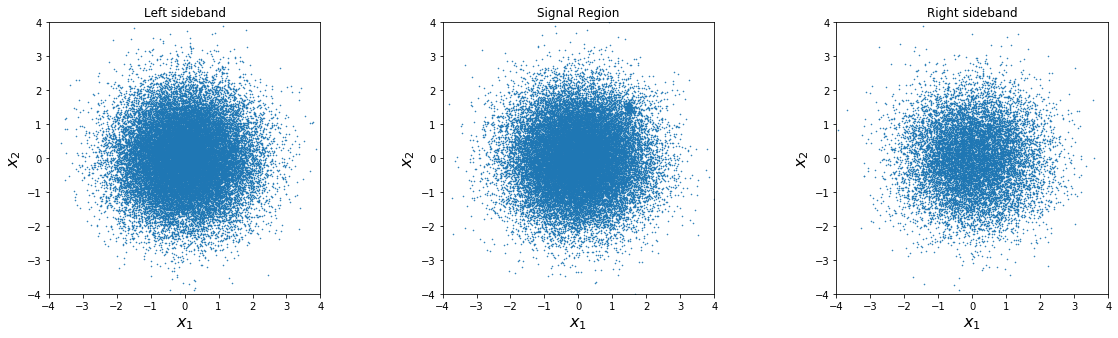

Signal highlighted:


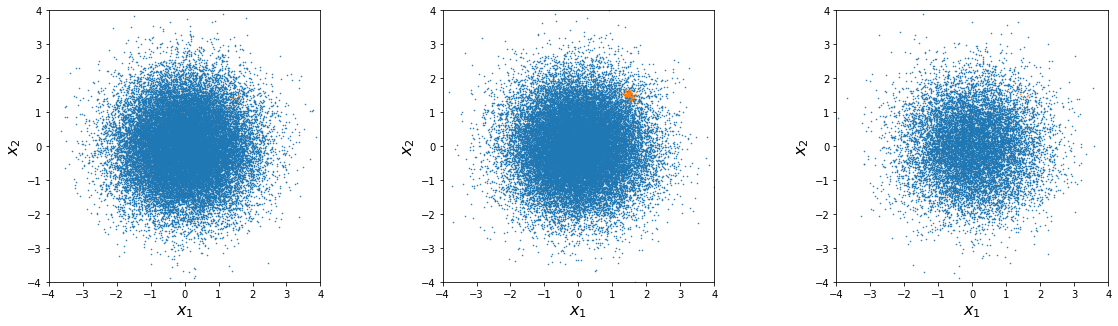

In [9]:
print("Signal + bg:")
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
for bin_i in [13,14]:
    plt.scatter(bgevents[bin_i][:,0],bgevents[bin_i][:,1],s=0.3,color='C0')
    plt.scatter(signalevents[bin_i][:,0],signalevents[bin_i][:,1],s=0.3,color='C0')
plt.gca().set_aspect(1.)
plt.title("Left sideband")
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.subplot(1, 3, 2)
for bin_i in [15,16,17]:
    plt.scatter(bgevents[bin_i][:,0],bgevents[bin_i][:,1],s=0.3,color='C0')
    plt.scatter(signalevents[bin_i][:,0],signalevents[bin_i][:,1],s=0.3,color='C0')
plt.gca().set_aspect(1.)
plt.title("Signal Region")
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.subplot(1, 3, 3)    
for bin_i in [18,19]:
    plt.scatter(bgevents[bin_i][:,0],bgevents[bin_i][:,1],s=0.3,color='C0')
    plt.scatter(signalevents[bin_i][:,0],signalevents[bin_i][:,1],s=0.3,color='C0')
plt.gca().set_aspect(1.)
plt.title("Right sideband")
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.show()

print("Signal highlighted:")
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
for bin_i in [13,14]:
    plt.scatter(bgevents[bin_i][:,0],bgevents[bin_i][:,1],s=0.3,color='C0')
    plt.scatter(signalevents[bin_i][:,0],signalevents[bin_i][:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.subplot(1, 3, 2)
for bin_i in [15,16,17]:
    plt.scatter(bgevents[bin_i][:,0],bgevents[bin_i][:,1],s=0.3,color='C0')
    plt.scatter(signalevents[bin_i][:,0],signalevents[bin_i][:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.subplot(1, 3, 3)    
for bin_i in [18,19]:
    plt.scatter(bgevents[bin_i][:,0],bgevents[bin_i][:,1],s=0.3,color='C0')
    plt.scatter(signalevents[bin_i][:,0],signalevents[bin_i][:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])


plt.show()

## Section 2: Machine Learning

Import modules and set up basic variables

In [10]:
import gc
import math
import time

from sklearn import preprocessing

import keras as keras
from keras import backend as K

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from cwola_utils_copy import AddPredictionsToScatter_nestedcrossval
from cwola_utils_copy import model_ensemble
from cwola_utils_copy import check_eff
from cwola_utils_copy import print_scatter_checkpoint

output_prefix = 'CWoLa-Hunting-2D-toy'

kfolds = 4
checkeff = 0.005
patience = 1000
ntries = 1
bin_i=16
axes_list=[[0,1]]
axes_labels=[['x','y']]
preprocess=None
numvars=2
batch_size=2000

rates = np.array([0.5,0.95,0.99,0.998])
colors=['silver','grey','khaki','goldenrod','firebrick']

Using TensorFlow backend.


### 2a. A Single Training Run

Do a single training run and show how the NN evolves during training

#### Fig J4

 k = 0 l = 1
Now training model  1  of  1


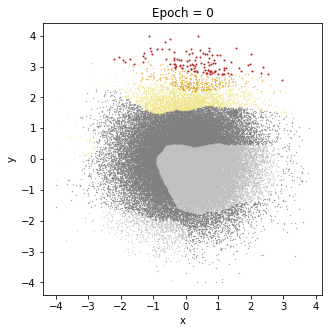

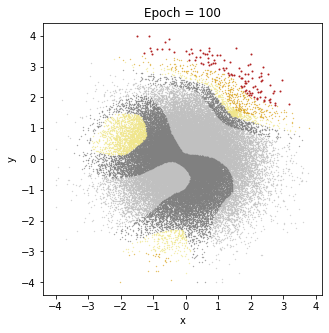

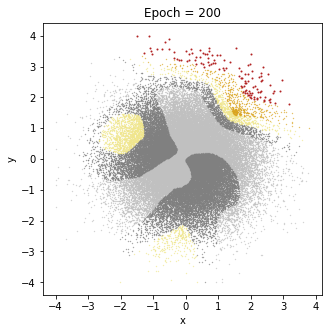

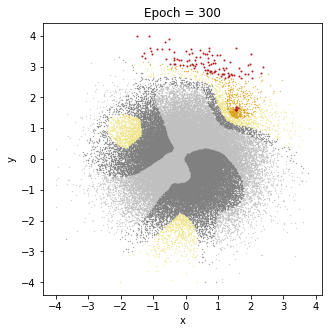

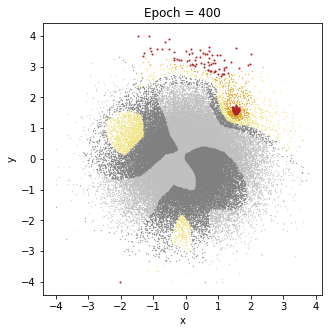

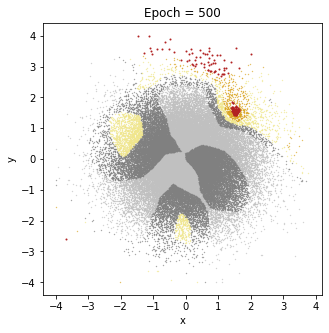

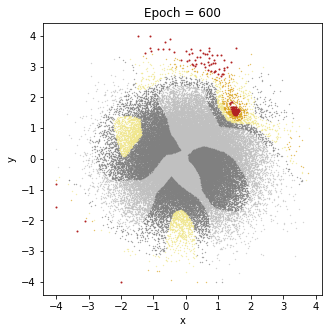

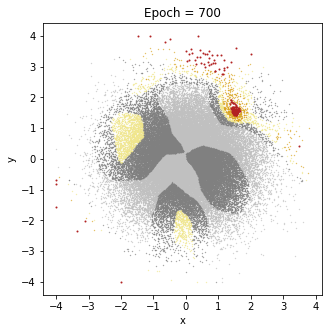

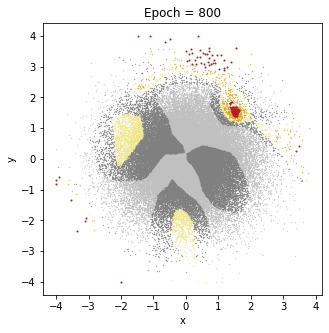

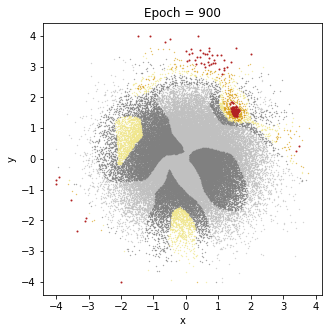

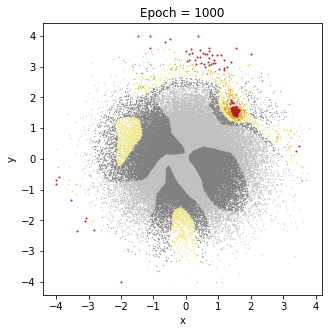

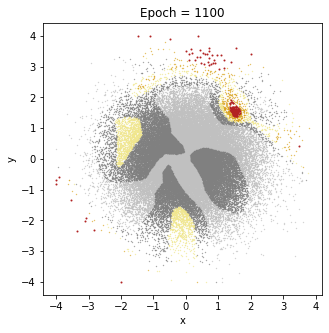

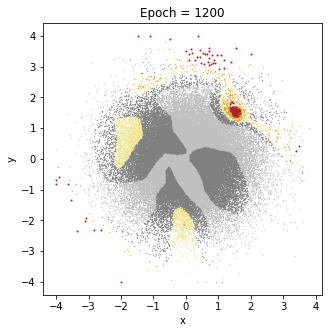

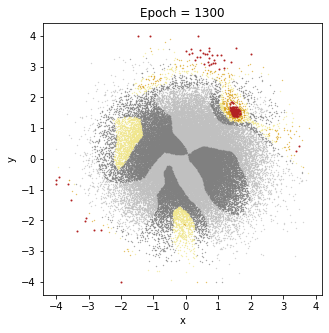

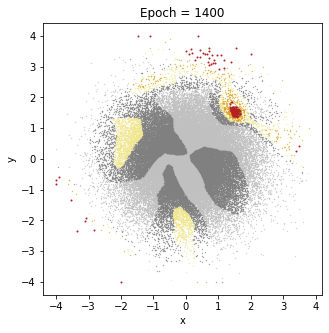

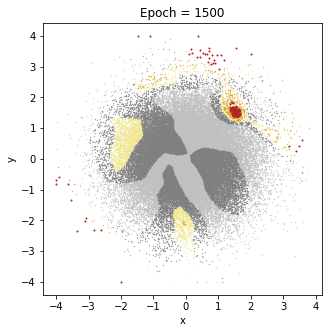

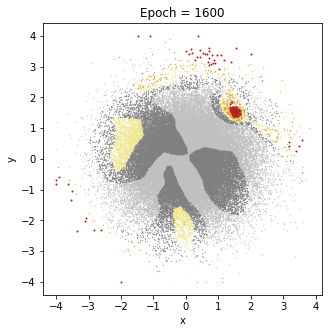

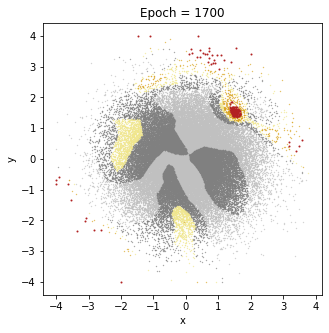

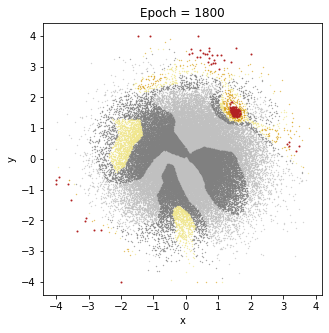

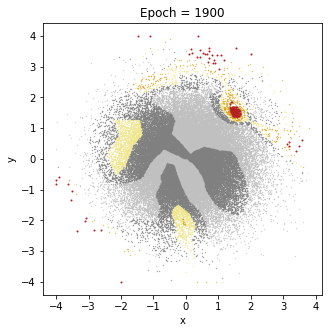

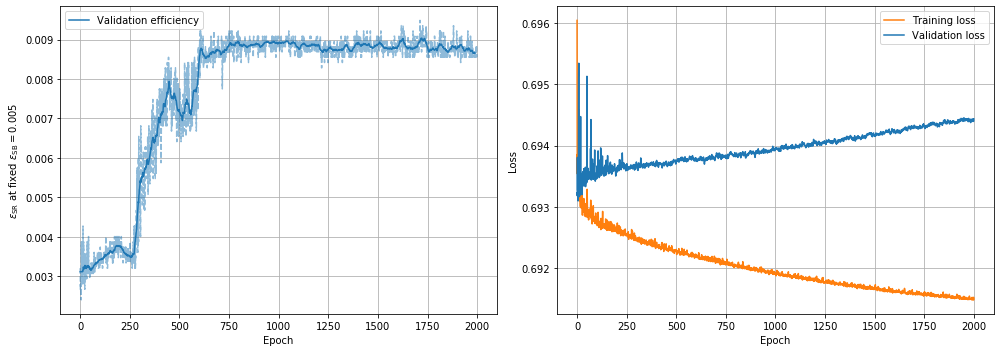

Selected Model:


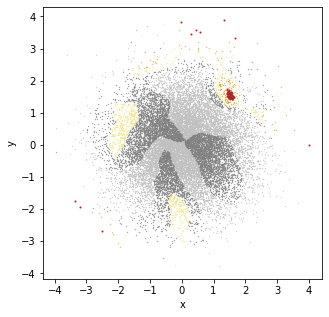

Elapsed Time =  268.11976528167725


In [10]:
times = list()


model_utils = model_ensemble(bg_plus_signal_binned, bin_i = bin_i, kfolds=kfolds, eff_for_thresh = checkeff)

i=0
k=0
l=1

print(" k =", k, "l =", l)
#Naming convention for model files.
checkpoint_name = output_prefix + "_" + str(bin_i) + "_[" + str(k) + "," + str(l) + "]_" + str(i)
start = time.time()

data_train, data_valid, labels_train, labels_valid, weights_train, weights_valid = model_utils.get_trainval_data(k,l)

print("Now training model ", i + 1, " of ", ntries)

K.clear_session()
#Following hyperparams seem to work well. Not done systematic optimization. Maybe something else works much better.
myoptimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.99, epsilon=1e-08, decay=0.0005)

#Custom callback to record tpr at fixed fpr (set by eff_rate), where tpr and fpr refer to signal and sideband regions rather than truth-labels.
my_check_eff = check_eff(verbose=0,
                         filename = checkpoint_name + '_best.h5',
                         patience = patience,
                         min_epoch=50,
                         batch_size=batch_size,
                         plot_period=50,
                         eff_rate = checkeff,
                         plotmode="print",avg_length=20)

#Custom callback for printing scatter plots every few epochs. Useful for troubleshooting, but slows down training considerably.
my_print = print_scatter_checkpoint(filename = checkpoint_name,
                                    axes_list = axes_list,
                                    axes_labels = axes_labels,
                                    period=100,
                                    training_data=np.append(data_train,data_valid,axis=0),
                                    training_labels=np.append(labels_train,labels_valid,axis=0),
                                    preprocess=preprocess,
                                    rates=rates,
                                    colors=colors,
                                    mode = "show")

mycallbacks=[my_print,
    my_check_eff]
#mycallbacks=[]

#Following seems to work well for benchmarks. Not systematically optimized. I basically just played around until something worked.
#However, bias initialization seems very important. Keras relu by default initializes to 0 bias, and especially in the first layer will not move from that initialization during training. This is very suboptimal.
model = Sequential()
model.add(Dense(64, input_dim=numvars,use_bias=True,
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.5)))
model.add(keras.layers.LeakyReLU(alpha=0.01))
#model.add(Dropout(0.1))
model.add(Dense(64, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
#model.add(Dropout(0.1))
model.add(Dense(32, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
#model.add(Dropout(0.1))
model.add(Dense(16, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
model.add(Dense(8, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=myoptimizer,
              loss='binary_crossentropy')

model_hist = model.fit(data_train, labels_train, epochs=2000, batch_size=batch_size,
                       validation_data=(data_valid, labels_valid, weights_valid),
                       callbacks=mycallbacks,verbose=0,
                       sample_weight = weights_train)

del model
K.clear_session()           #Otherwise TensorFlow eats up all GPU memory with previous models.


model = keras.models.load_model(checkpoint_name + "_best.h5")
model_utils.add_model(model, None, k, l,checkpoint_name + "_best.h5")
plt.close('all')

print("Selected Model:")
model_utils.print_scatter_onemodel_signalplussidebandregion(k,l,i,
                                                            axes_list=axes_list,
                                                            axes_labels=axes_labels,
                                                            rates=rates,
                                                            colors=colors)

for i in range(5):
    gc.collect()
end = time.time()

times.append(end-start)
print("Elapsed Time = ", times[-1])

Run full cross validation procedure, show trained and ensemble classifiers. For each individual classifier, the selection is shown on all training and validation data for that k-fold. After training all the classifiers in an ensemble for a k-fold, the selection of the ensemble classifier is shown on the test k-fold itself.

#### Fig J5

 k = 0 l = 1
Now training model  1  of  1
Elapsed Time =  176.93954157829285
 k = 0 l = 2
Now training model  1  of  1
Elapsed Time =  200.34506154060364
 k = 0 l = 3
Now training model  1  of  1
Elapsed Time =  174.1819441318512
Ensemble model for k = 0


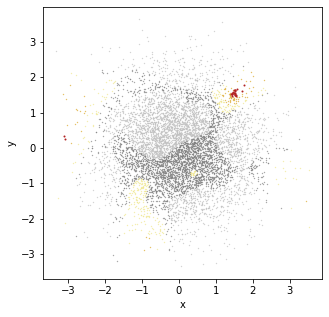

 k = 1 l = 0
Now training model  1  of  1
Elapsed Time =  135.39835691452026
 k = 1 l = 2
Now training model  1  of  1
Elapsed Time =  132.73584461212158
 k = 1 l = 3
Now training model  1  of  1
Elapsed Time =  137.36510348320007
Ensemble model for k = 1


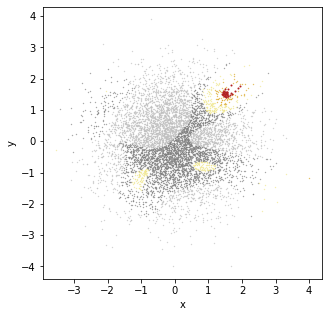

 k = 2 l = 0
Now training model  1  of  1
Elapsed Time =  208.262113571167
 k = 2 l = 1
Now training model  1  of  1
Elapsed Time =  160.67970418930054
 k = 2 l = 3
Now training model  1  of  1
Elapsed Time =  241.44357085227966
Ensemble model for k = 2


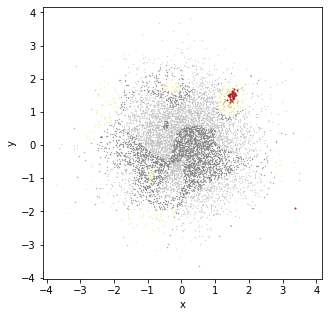

 k = 3 l = 0
Now training model  1  of  1
Elapsed Time =  149.65909123420715
 k = 3 l = 1
Now training model  1  of  1
Elapsed Time =  192.19983410835266
 k = 3 l = 2
Now training model  1  of  1
Elapsed Time =  141.60561895370483
Ensemble model for k = 3


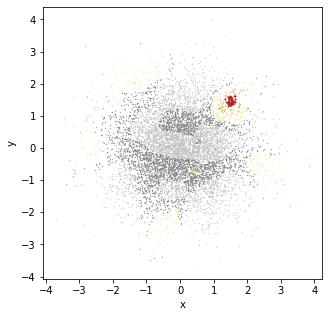

In [12]:
times = list()


model_utils = model_ensemble(bg_plus_signal_binned, bin_i = bin_i, kfolds=kfolds, eff_for_thresh = checkeff)
for k in range(kfolds):
    #print('Starting kfold', k, 'of', kfolds-1)
    #Loop over validation sets
    for l in range(kfolds):
        if l == k:
            continue
        #print('Starting lfold', l, 'of', kfolds-1)

        data_train, data_valid, labels_train, labels_valid, weights_train, weights_valid = model_utils.get_trainval_data(k,l)

        for i in range(ntries):
            print(" k =", k, "l =", l)
            #Naming convention for model files.
            checkpoint_name = output_prefix + "_" + str(bin_i) + "_[" + str(k) + "," + str(l) + "]_" + str(i)
            start = time.time()


            print("Now training model ", i + 1, " of ", ntries)

            K.clear_session()
            #Following hyperparams seem to work well. Not done systematic optimization. Maybe something else works much better.
            myoptimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.99, epsilon=1e-08, decay=0.0005)

            #Custom callback to record tpr at fixed fpr (set by eff_rate), where tpr and fpr refer to signal and sideband regions rather than truth-labels.
            my_check_eff = check_eff(verbose=-1,
                                     filename = checkpoint_name + '_best.h5',
                                     patience = patience,
                                     min_epoch=50, batch_size=batch_size,
                                     plot_period=50,eff_rate=checkeff,
                                     plotmode="print",avg_length=20)
            
            #Custom callback for printing scatter plots every few epochs. Useful for troubleshooting, but slows down training considerably.
            my_print = print_scatter_checkpoint(filename = checkpoint_name,
                                                axes_list = axes_list,
                                                axes_labels = axes_labels,
                                                period=50,
                                                training_data=np.append(data_train,data_valid,axis=0),
                                                training_labels=np.append(labels_train,labels_valid,axis=0),
                                                preprocess=preprocess,
                                                rates=rates,
                                                colors=colors)

            mycallbacks=[#my_print,
                my_check_eff]

            #Following seems to work well for benchmarks. Not systematically optimized. I basically just played around until something worked.
            #However, bias initialization seems very important. Keras relu by default initializes to 0 bias, and especially in the first layer will not move from that initialization during training. This is very suboptimal.
            model = Sequential(name = "model_" + str(k) + "_" + str(l) + "_" + str(i))
            model.add(Dense(64, input_dim=numvars,use_bias=True,
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.5)))
            model.add(keras.layers.LeakyReLU(alpha=0.01))
            #model.add(Dropout(0.1))
            model.add(Dense(64, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            #model.add(Dropout(0.1))
            model.add(Dense(32, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            #model.add(Dropout(0.1))
            model.add(Dense(16, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            model.add(Dense(8, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            model.add(Dense(1, activation='sigmoid'))

            model.compile(optimizer=myoptimizer,
                          loss='binary_crossentropy')

            model_hist = model.fit(data_train, labels_train, epochs=2000, batch_size=batch_size,
                                   validation_data=(data_valid, labels_valid, weights_valid),
                                   callbacks=mycallbacks,verbose=0,
                                   sample_weight = weights_train)

            del model
            K.clear_session()           #Otherwise TensorFlow eats up all GPU memory with previous models.


            model = keras.models.load_model(checkpoint_name + "_best.h5")
            model_utils.add_model(model, None, k, l,checkpoint_name + "_best.h5")
            plt.close('all')
            


            #print("Selected Model:")
            #model_utils.print_scatter_onemodel_signalplussidebandregion(k,l,i,axes_list=axes_list,axes_labels=axes_labels,
            #                                                            rates=rates,
            #                                                            colors=colors)

            for i in range(5):
                gc.collect()
            end = time.time()

            times.append(end-start)
            print("Elapsed Time = ", times[-1])


    #Make an ensemble model using the average of the best models trained using the (k-1) training-validation splits. Save this as a single model.
    ensemble_model = model_utils.makeandsave_ensemble_model(k,output_prefix + "_" + str(bin_i) + "_ensemble_k" + str(k) + ".h5")
    plt.close('all')
    
    print("Ensemble model for k =", k)
    model_utils.print_scatter_avg_onek_signalplussidebandregion(k,axes_list=axes_list,axes_labels=axes_labels,
                                                                   rates=rates,
                                                                   colors=colors)
    del ensemble_model
    K.clear_session()




#### Fig J6

Show full cross-validated NN selection

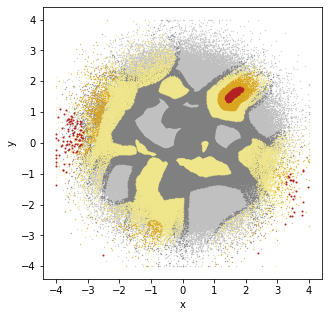

[array([0.5  , 0.9  , 0.99 , 0.999])]

In [13]:
model_utils.load_all_ensemble_models()

kset_data, kset_prediction = model_utils.avg_model_predict_kset()
plt.close('all')

AddPredictionsToScatter_nestedcrossval(kset_data,kset_prediction,
                                       axes_list = axes_list, axes_labels=axes_labels,                                       
                                       rates = np.array([0.5,0.9,0.99,0.999]),
                                    colors=['silver','grey','khaki','goldenrod','firebrick'])

### Section 3: Do p-value calculation

In [14]:
bin_widths_GeV = bin_widths*1000
bin_boundaries_GeV = bin_boundaries*1000

In [20]:
# Cut at 1% efficiency
chosen_effs = [0.01]

ymin=1E8
ymax=0
plt.close('all')

file = open(output_prefix + '_' + str(bin_i) +  '_bincounts.dat','w')
bincutcountslist = []

for eff in chosen_effs:
    print("Setting eff to ", eff)
    bincutcounts, bincutcountsset = model_utils.get_bin_cut_counts_all(eff)
    bindensities = bincutcounts / bin_widths_GeV
    print("Counts after cut: ", bincutcounts)
    #print("St. Dev. after cut: ", binstd)
    file.write(str(eff))
    file.write('\t')
    for entry in bincutcounts:
        file.write(str(entry))
        file.write('\t')
    file.write('\n')
    bincutcountslist.append(bincutcounts)



file.close()

Setting eff to  0.01
Counts after cut:  [1391 1240 1056  891  718  623  519  472  383  319  298  245  208  163
  142  144  165  127   79   58   39   39   43   30   24   18   13   13
   10   16    7    7    1    4    1    2    3    2    3]


#### Fig J7

Getting p-value for eff: 0.01
fit params:  [0.2137202  8.81117154 5.93647128]


Goodness:  KstestResult(statistic=0.15112013915439038, pvalue=0.3497793582493345)


numerator:  dict_items([('fun', -4.587228497495289), ('jac', array([0.])), ('nfev', 30), ('nit', 5), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([20.54484325])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -26.19214238853965), ('jac', array([0., 0.])), ('nfev', 27), ('nit', 7), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([2.01248171e-03, 1.35188801e+02])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  6.6404004422168335
p0 =  1.5641599127036443e-11


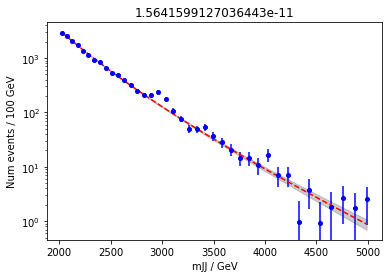

In [22]:
from cwola_utils_copy import get_p_value

for i, eff in enumerate(chosen_effs):
    print("Getting p-value for eff:", eff)

    pplotname = output_prefix + '_pplot_' + str(eff) + '.png'
    get_p_value(bincutcountslist[i],bin_boundaries_GeV,mask=[bin_i-1,bin_i,bin_i+1],verbose=1,
                plotfile="show")

## Section 4: Repeat for a background-only sample

#### Fig J8

Starting kfold 0 of 3
Starting lfold 1 of 3
 k = 0 l = 1
Now training model  1  of  1
Elapsed Time =  154.23129415512085
Starting lfold 2 of 3
 k = 0 l = 2
Now training model  1  of  1
Elapsed Time =  170.1157546043396
Starting lfold 3 of 3
 k = 0 l = 3
Now training model  1  of  1
Elapsed Time =  142.9987189769745
Ensemble model for k = 0


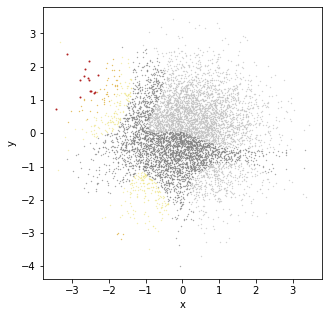

Starting kfold 1 of 3
Starting lfold 0 of 3
 k = 1 l = 0
Now training model  1  of  1
Elapsed Time =  237.056809425354
Starting lfold 2 of 3
 k = 1 l = 2
Now training model  1  of  1
Elapsed Time =  142.00828289985657
Starting lfold 3 of 3
 k = 1 l = 3
Now training model  1  of  1
Elapsed Time =  152.6378722190857
Ensemble model for k = 1


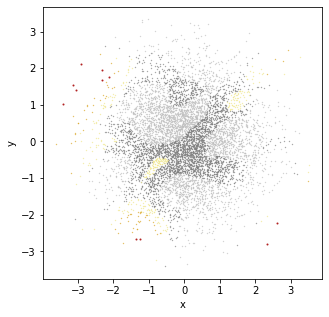

Starting kfold 2 of 3
Starting lfold 0 of 3
 k = 2 l = 0
Now training model  1  of  1
Elapsed Time =  182.29216599464417
Starting lfold 1 of 3
 k = 2 l = 1
Now training model  1  of  1
Elapsed Time =  162.44996881484985
Starting lfold 3 of 3
 k = 2 l = 3
Now training model  1  of  1
Elapsed Time =  261.9149785041809
Ensemble model for k = 2


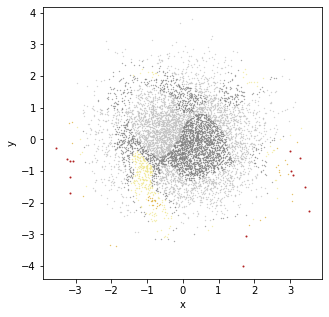

Starting kfold 3 of 3
Starting lfold 0 of 3
 k = 3 l = 0
Now training model  1  of  1
Elapsed Time =  267.5968840122223
Starting lfold 1 of 3
 k = 3 l = 1
Now training model  1  of  1
Elapsed Time =  257.00606656074524
Starting lfold 2 of 3
 k = 3 l = 2
Now training model  1  of  1
Elapsed Time =  249.92463874816895
Ensemble model for k = 3


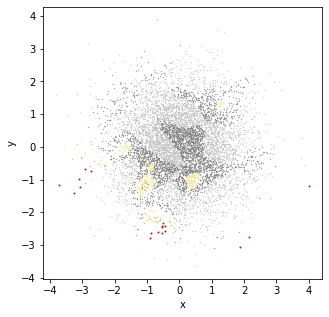

In [24]:
times = list()


model_utils = model_ensemble(bgevents, bin_i = bin_i, kfolds=kfolds, eff_for_thresh = checkeff)
for k in range(kfolds):
    print('Starting kfold', k, 'of', kfolds-1)
    #Loop over validation sets
    for l in range(kfolds):
        if l == k:
            continue
        print('Starting lfold', l, 'of', kfolds-1)

        data_train, data_valid, labels_train, labels_valid, weights_train, weights_valid = model_utils.get_trainval_data(k,l)

        for i in range(ntries):
            print(" k =", k, "l =", l)
            #Naming convention for model files.
            checkpoint_name = output_prefix + "_" + str(bin_i) + "_[" + str(k) + "," + str(l) + "]_" + str(i)
            start = time.time()


            print("Now training model ", i + 1, " of ", ntries)

            K.clear_session()
            #Following hyperparams seem to work well. Not done systematic optimization. Maybe something else works much better.
            myoptimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.99, epsilon=1e-08, decay=0.0005)

            #Custom callback to record tpr at fixed fpr (set by eff_rate), where tpr and fpr refer to signal and sideband regions rather than truth-labels.
            my_check_eff = check_eff(verbose=-1,
                                     filename = checkpoint_name + '_best.h5',
                                     patience = patience,
                                     min_epoch=50, batch_size=batch_size,
                                     plot_period=50,eff_rate=checkeff,
                                     plotmode="print",avg_length=20)

            mycallbacks=[my_check_eff]

            mycallbacks=[#my_print,
                my_check_eff]

            #Following seems to work well for benchmarks. Not systematically optimized. I basically just played around until something worked.
            #However, bias initialization seems very important. Keras relu by default initializes to 0 bias, and especially in the first layer will not move from that initialization during training. This is very suboptimal.
            model = Sequential(name = "model_" + str(k) + "_" + str(l) + "_" + str(i))
            model.add(Dense(64, input_dim=numvars,use_bias=True,
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.5)))
            model.add(keras.layers.LeakyReLU(alpha=0.01))
            #model.add(Dropout(0.1))
            model.add(Dense(64, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            #model.add(Dropout(0.1))
            model.add(Dense(32, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            #model.add(Dropout(0.1))
            model.add(Dense(16, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            model.add(Dense(8, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            model.add(Dense(1, activation='sigmoid'))

            model.compile(optimizer=myoptimizer,
                          loss='binary_crossentropy')

            model_hist = model.fit(data_train, labels_train, epochs=2000, batch_size=batch_size,
                                   validation_data=(data_valid, labels_valid, weights_valid),
                                   callbacks=mycallbacks,verbose=0,
                                   sample_weight = weights_train)

            del model
            K.clear_session()           #Otherwise TensorFlow eats up all GPU memory with previous models.


            model = keras.models.load_model(checkpoint_name + "_best.h5")
            model_utils.add_model(model, None, k, l,checkpoint_name + "_best.h5")
            plt.close('all')
            
            for i in range(5):
                gc.collect()
            end = time.time()

            times.append(end-start)
            print("Elapsed Time = ", times[-1])

    #Make an ensemble model using the average of the best models trained using the (k-1) training-validation splits. Save this as a single model.
    ensemble_model = model_utils.makeandsave_ensemble_model(k,output_prefix + "_" + str(bin_i) + "_ensemble_k" + str(k) + ".h5")
    plt.close('all')
    
    print("Ensemble model for k =", k)
    model_utils.print_scatter_avg_onek_signalplussidebandregion(k,axes_list=axes_list,axes_labels=axes_labels,
                                                                   rates=rates,
                                                                   colors=colors)
    del ensemble_model
    K.clear_session()




#### Fig J9

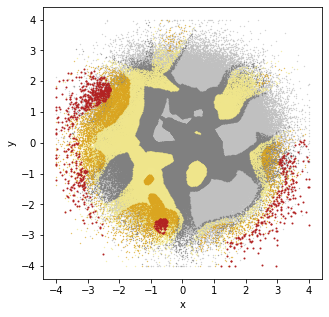

[array([0.5  , 0.9  , 0.99 , 0.999])]

In [25]:
model_utils.load_all_ensemble_models()

kset_data, kset_prediction = model_utils.avg_model_predict_kset()
plt.close('all')

AddPredictionsToScatter_nestedcrossval(kset_data,kset_prediction,
                                       axes_list = axes_list, axes_labels=axes_labels,                                       
                                       rates = np.array([0.5,0.9,0.99,0.999]),
                                    colors=['silver','grey','khaki','goldenrod','firebrick'])

Do p-value calculation

In [26]:
bin_widths_GeV = bin_widths*1000
bin_boundaries_GeV = bin_boundaries*1000

In [27]:
chosen_effs = [0.01]

ymin=1E8
ymax=0
plt.close('all')

file = open(output_prefix + '_' + str(bin_i) +  '_bincounts.dat','w')
bincutcountslist = []

for eff in chosen_effs:
    print("Setting eff to ", eff)
    bincutcounts, bincutcountsset = model_utils.get_bin_cut_counts_all(eff)
    bindensities = bincutcounts / bin_widths_GeV
    print("Counts after cut: ", bincutcounts)
    #print("St. Dev. after cut: ", binstd)
    file.write(str(eff))
    file.write('\t')
    for entry in bincutcounts:
        file.write(str(entry))
        file.write('\t')
    file.write('\n')
    bincutcountslist.append(bincutcounts)



file.close()

Setting eff to  0.01
Counts after cut:  [1540 1275  995  877  779  627  537  472  401  323  272  248  180  179
  139  104   92   87   73   64   42   47   31   20   16   21   13   17
   11   11    4    2    6    3    2    4    1    0    1]


#### Fig J10

Getting p-value for eff: 0.01
fit params:  [0.09817359 8.15308929 6.31905701]


Goodness:  KstestResult(statistic=0.1073313667472855, pvalue=0.8012604938840426)


numerator:  dict_items([('fun', -0.009069353320001028), ('jac', array([0.])), ('nfev', 8), ('nit', 3), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([-0.89738735])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -0.07562018841099416), ('jac', array([0., 0.])), ('nfev', 24), ('nit', 6), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([-2.48011825e-04, -5.58248788e+00])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  0
p0 =  0.5


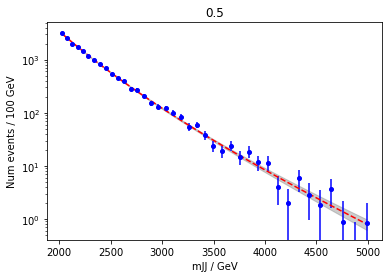

In [28]:
from cwola_utils_copy import get_p_value

for i, eff in enumerate(chosen_effs):
    print("Getting p-value for eff:", eff)

    pplotname = output_prefix + '_pplot_' + str(eff) + '.png'
    get_p_value(bincutcountslist[i],bin_boundaries_GeV,mask=[bin_i-1,bin_i,bin_i+1],verbose=1,
                plotfile="show")